In [1]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from numpy import dstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
#Loading dataset
d1 = pd.read_csv('UNSW_NB15_training-set.csv')
t1 = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
data = d1.append(t1)

In [4]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,166662.000000,166662.000000,166662.000000,166662.000000,1.666620e+05,1.666620e+05,1.666620e+05,166662.000000,166662.000000,1.666620e+05,1.666620e+05,166662.000000,166662.000000,166662.000000,166662.000000,1.666620e+05,166661.000000,166661.000000,1.666610e+05,1.666610e+05,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,1.666610e+05,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000,166661.000000
mean,41671.988174,1.164153,23.562882,24.221328,8.414016e+03,1.905523e+04,6.442390e+04,155.426522,90.992116,5.915110e+07,1.009699e+06,5.396779,8.886999,590.087438,119.884777,6.327876e+03,706.639130,147.445197,1.215825e+09,1.211002e+09,144.117958,0.049549,0.025700,0.023849,146.628929,159.437919,0.103972,2.288530e+03,7.263385,1.085437,4.364716,3.318137,2.460726,5.602072,0.013518,0.013566,0.140543,5.278643,6.953708,0.008010,0.474970
std,24066.028680,5.266127,131.608377,120.080503,1.651203e+05,1.575075e+05,1.395050e+05,108.215298,111.473245,1.899897e+08,2.939834e+06,62.368513,57.489211,5314.017932,1269.034125,5.402019e+04,4605.763863,125.928289,1.415839e+09,1.412259e+09,126.408499,0.102486,0.060520,0.050280,211.433385,280.866097,0.615524,4.013295e+04,8.957780,1.052306,6.501615,6.345073,4.507918,8.970670,0.116926,0.117433,0.739221,7.053674,8.922435,0.089141,0.499375
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20833.250000,0.000009,2.000000,0.000000,2.000000e+02,0.000000e+00,2.960001e+01,31.000000,0.000000,1.153618e+04,0.000000e+00,0.000000,0.000000,0.009000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41666.000000,0.033882,10.000000,6.000000,6.900000e+02,3.040000e+02,1.702051e+03,254.000000,29.000000,5.168142e+05,4.271456e+03,2.000000,1.000000,1.196000,0.540714,4.262597e+01,7.299877,255.000000,5.035649e+08,4.965252e+08,255.000000,0.000627,0.000496,0.000124,77.000000,45.000000,0.000000,0.000000e+00,4.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,0.000000
75%,62498.750000,0.754346,16.000000,18.000000,1.915500e+03,1.838000e+03,1.111111e+05,254.000000,252.000000,5.066666e+07,3.474932e+05,4.000000,4.000000,61.602361,60.784821,3.187188e+03,137.017547,255.000000,2.396302e+09,2.389231e+09,255.000000,0.091676,0.043987,0.045674,101.000000,103.000000,0.000000,0.000000e+00,8.000000,2.000000,4.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,1.000000
max,84330.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.000000,4.294950e+09,4.294882e+09,255.000000,3.821465,3.226788,2.928778,1504.000000,1500.000000,155.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [5]:
#Dropping attack category column since problem is binary classification
data.drop(columns = 'attack_cat', inplace = True)

In [6]:
#Dropping NaN values
data.dropna(inplace = True)

In [7]:
#Checking for null values in the dataset
data.isnull().sum().sum()

0

In [8]:
#Finding percentage of normal and attack classes where attack is represented by 1 and normal is represented by 0
nortr, attacktr = data['label'].value_counts()[0] / len(data.index), data['label'].value_counts()[1] / len(data.index)
#Displaying the percentage
print("Dataset contains {} % of normal classes and {} % of attack classes".format(nortr*100, attacktr*100))

Dataset contains 52.50298510149345 % of normal classes and 47.49701489850655 % of attack classes


In [9]:
data['service'].replace('-',np.nan,inplace=True)

In [10]:
data.isnull().sum()

id                        0
dur                       0
proto                     0
service              103766
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm    

In [11]:
data.dropna(inplace=True)

In [12]:
data.shape

(62895, 44)

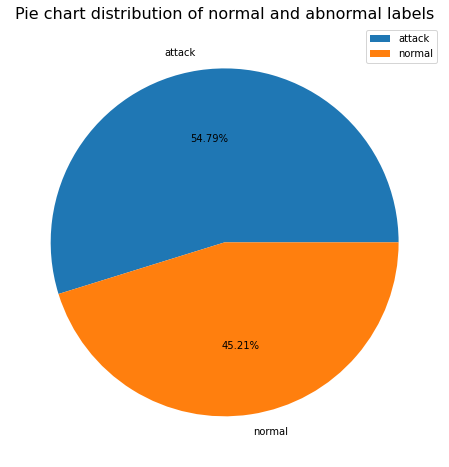

In [13]:
plt.figure(figsize=(8,8))
plt.pie(data.label.value_counts(),labels=['attack','normal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

In [14]:
data['label'].value_counts()

1.0    34463
0.0    28432
Name: label, dtype: int64

In [15]:
label_feature = ['label']
categorical_features = ['proto', 'service', 'state']

In [16]:
drop_features = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']
numerical_features = list(set(data.columns) - set(label_feature) - set(categorical_features) - set(drop_features))

In [17]:
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [18]:
serv = OneHotEncoder()
pro = OneHotEncoder()
sta = OneHotEncoder()

def encode(data):

    X = serv.fit_transform(data['service'].values.reshape(-1, 1))
    X2 = pro.fit_transform(data['proto'].values.reshape(-1, 1))
    X3 = sta.fit_transform(data['state'].values.reshape(-1, 1))

    data = pd.concat([data,
                      pd.DataFrame(X2.toarray(), columns=['proto_'+i for i in pro.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in serv.categories_[0]]),
                      pd.DataFrame(X3.toarray(), columns=['state_'+i for i in sta.categories_[0]])],
                      axis=1)

    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [19]:
data.reset_index(drop=True)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,36,0.016398,tcp,http,FIN,0.000845,0.000726,0.000052,0.000080,0.000017,62,252,0.000003,0.000372,0.000376,0.000363,0.007813,0.008929,0.005354,0.000416,255.0,0.184917,0.378310,255.0,0.138574,0.211241,0.068943,0.029412,0.098000,1.0,184.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
1,41,0.025588,tcp,http,FIN,0.000845,0.000908,0.000053,0.000086,0.000012,62,252,0.000002,0.000265,0.000376,0.000363,0.012184,0.011368,0.010775,0.000527,255.0,0.164953,0.731456,255.0,0.120962,0.201924,0.053864,0.030166,0.084667,1.0,187.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,46,0.017656,tcp,http,FIN,0.000845,0.000726,0.000053,0.000077,0.000016,62,252,0.000002,0.000334,0.000376,0.000363,0.008412,0.009498,0.005510,0.000552,255.0,0.431617,0.279972,255.0,0.184401,0.250346,0.102824,0.030166,0.094667,1.0,165.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0
3,50,0.016509,tcp,http,FIN,0.000845,0.000908,0.000051,0.000096,0.000019,62,252,0.000003,0.000459,0.000376,0.000363,0.007866,0.007191,0.006477,0.000310,255.0,0.355962,0.248345,255.0,0.121715,0.164188,0.068250,0.027903,0.094000,1.0,261.0,2.0,1.0,18.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
4,73,0.021725,tcp,http,FIN,0.001033,0.000726,0.000058,0.000076,0.000015,62,252,0.000002,0.000268,0.000376,0.000363,0.008469,0.012540,0.005862,0.000545,255.0,0.275432,0.186876,255.0,0.093957,0.145208,0.046032,0.024133,0.093333,1.0,157.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62890,84311,0.008673,tcp,http,FIN,0.000845,0.000726,0.000064,0.000067,0.000033,62,252,0.000006,0.000592,0.000376,0.000363,0.004132,0.004766,0.002640,0.000204,255.0,0.620555,0.942818,255.0,0.061810,0.102918,0.027618,0.041478,0.082000,1.0,56.0,4.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,1.0,2.0,3.0,0.0,1.0
62891,84312,0.057878,tcp,smtp,FIN,0.005730,0.002541,0.004064,0.000146,0.000026,62,252,0.000057,0.000212,0.005264,0.001453,0.004069,0.008935,0.005337,0.000517,255.0,0.568941,0.472062,255.0,0.080375,0.123434,0.039660,0.677979,0.050667,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
62892,84315,0.015370,tcp,ftp-data,FIN,0.000658,0.000908,0.000021,0.000256,0.000018,62,252,0.000001,0.001307,0.000188,0.000545,0.009416,0.006877,0.008178,0.017447,255.0,0.786691,0.268330,255.0,0.080474,0.108223,0.045245,0.002262,0.250000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
62893,84320,0.126387,udp,dns,INT,0.003288,0.000000,0.000550,0.000000,0.000005,254,0,0.000004,0.000000,0.000000,0.000000,0.015484,0.000000,0.000218,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.134238,0.000000,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [20]:
data.shape

(62895, 44)

In [21]:
catval = ['proto', 'service', 'state']
data_cat = data[catval].copy()
data_cat.head()

,proto,service,state
35,tcp,http,FIN
40,tcp,http,FIN
45,tcp,http,FIN
49,tcp,http,FIN
72,tcp,http,FIN


In [22]:
data_cat = pd.get_dummies(data_cat,columns=catval)
data = pd.concat([data, data_cat],axis=1)

In [23]:
data.drop(columns=catval,inplace=True)

In [24]:
X = data.drop(columns=['label'],axis=1)
Y = data['label']

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [26]:
#ANOVA Feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_classif, k=15)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [27]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [28]:
#Evaluation Metrics for the Multilayer Perceptrons
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        y_pred = tf.greater_equal(y_pred, 0.5)
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [29]:
#Evaluation Metrics for the Multilayer Perceptrons
def plot_loss(model_history):
  train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
  valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(train_loss, '--', color=color, label='Train Loss')
  ax1.plot(valid_loss, color=color, label='Valid Loss')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Loss')
  plt.show()

In [30]:
#Evaluation Metrics for the Multilayer Perceptrons
def plot_model_recall_fpr(model_history):
  train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
  valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
  train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
  valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Recall', color=color)
  ax1.set_ylim([-0.05,1.05])
  ax1.plot(train_recall, '--', color=color, label='Train Recall')
  ax1.plot(valid_recall, color=color, label='Valid Recall')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Recall and FPR')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
  ax2.plot(train_fpr, '--', color=color, label='Train FPR')
  ax2.plot(valid_fpr, color=color, label='Valid FPR')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([-0.05,1.05])
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc='upper right')
  plt.show()

In [31]:
#Evaluation Metrics for the Multilayer Perceptrons
def plot_train_history(history):
    # plot the cost and accuracy 
    loss_list = history['loss']
    val_loss_list = history['val_loss']
    accuracy_list = history['accuracy']
    val_accuracy_list = history['val_accuracy']
    # epochs = range(len(loss_list))

    # plot the cost
    plt.plot(loss_list, 'b', label='Training cost')
    plt.plot(val_loss_list, 'r', label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('Training and validation cost')
    plt.legend()

    plt.figure()
    
    # plot the accuracy
    plt.plot(accuracy_list, 'b', label='Training accuracy')
    plt.plot(val_accuracy_list, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iterations')
    plt.title('Training and validation accuracy')
    plt.legend()

In [32]:
#Models being used as base learners
#Model1 - 
mlp = Sequential()
mlp.add(Dense(units=128, input_dim=X_train_fs.shape[1], activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 232,705
Trainable params: 232,705
Non-trai

In [33]:
#Model2 - 
mlp2 = Sequential()
mlp2.add(Dense(units=128, input_dim=X_train_fs.shape[1], activation='relu'))
mlp2.add(Dense(256, activation='relu'))
mlp2.add(Dense(256, activation='relu'))
mlp2.add(Dense(256, activation='relu'))
mlp2.add(Dense(256, activation='relu'))
mlp2.add(Dense(1, activation='sigmoid'))
mlp2.summary()
mlp2.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2048      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 232,705
Trainable params: 232,705
Non-tr

In [34]:
#Model3 - 
mlp3 = Sequential()
mlp3.add(Dense(units=128, input_dim=X_train_fs.shape[1], activation='relu'))
mlp3.add(Dense(256, activation='relu'))
mlp3.add(Dense(256, activation='relu'))
mlp3.add(Dense(256, activation='relu'))
mlp3.add(Dense(256, activation='relu'))
mlp3.add(Dense(1, activation='sigmoid'))
mlp3.summary()
mlp3.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2048      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 232,705
Trainable params: 232,705
Non-tr

In [35]:
#Model4 - 
mlp4 = Sequential()
mlp4.add(Dense(units=128, input_dim=X_train_fs.shape[1], activation='relu'))
mlp4.add(Dense(256, activation='relu'))
mlp4.add(Dense(256, activation='relu'))
mlp4.add(Dense(256, activation='relu'))
mlp4.add(Dense(1, activation='sigmoid'))
mlp4.summary()
mlp4.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               2048      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [36]:
grid_parameters = [
    { #MLP
        'batch_size' : [1000, 500, 100],
        'epochs' : [80, 85, 90, 95, 100, 105, 110, 115, 120, 125],
        'validation_split' : [0.2],
        'verbose' : [0]
    },
    { #MLP2
        'batch_size' : [1000, 500, 100],
        'epochs' : [80, 85, 90, 95, 100, 105, 110, 115, 120, 125],
        'validation_split' : [0.2],
        'verbose' : [0]
    }, 
    { #MLP3
        'batch_size' : [1000, 500, 100],
        'epochs' : [80, 85, 90, 95, 100, 105, 110, 115, 120, 125],
        'validation_split' : [0.2],
        'verbose' : [0]
    },
    { #MLP3
        'batch_size' : [1000, 500, 100],
        'epochs' : [80, 85, 90, 95, 100, 105, 110, 115, 120, 125],
        'validation_split' : [0.2],
        'verbose' : [0]
    }
]

In [37]:
history = mlp.fit(x=X_train_fs,
                  y=y_train,
                  batch_size=1000,
                  epochs=85,validation_split = 0.2,
                  verbose=0).history

h2 = mlp2.fit(x=X_train_fs,
                  y=y_train,
                  batch_size=1000,
                  epochs=118,validation_split = 0.2,
                  verbose=0).history

h3 = mlp3.fit(x=X_train_fs,
                  y=y_train,
                  batch_size=1000,
                  epochs=90,validation_split = 0.2,
                  verbose=0).history

h4 = mlp4.fit(x=X_train_fs,
                  y=y_train,
                  batch_size=1000,
                  epochs=75,validation_split = 0.2,
                  verbose=0).history

In [38]:
test_results1 = mlp.evaluate(X_test_fs, y_test, verbose=1)
print(f'Test results1 -  Accuracy: {test_results1[1]*100}')
test_results2 = mlp2.evaluate(X_test_fs, y_test, verbose=1)
print(f'Test results2 -  Accuracy: {test_results2[1]*100}')
test_results3 = mlp3.evaluate(X_test_fs, y_test, verbose=1)
print(f'Test results3 -  Accuracy: {test_results3[1]*100}')
test_results4 = mlp4.evaluate(X_test_fs, y_test, verbose=1)
print(f'Test results4 -  Accuracy: {test_results4[1]*100}')

394/394 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9625 - false_positive_rate: 0.0607 - recall: 0.9818
Test results1 -  Accuracy: 96.24771475791931
394/394 [==============================] - 1s 2ms/step - loss: 0.0937 - accuracy: 0.9655 - false_positive_rate: 0.0392 - recall_1: 0.9694
Test results2 -  Accuracy: 96.54980301856995
394/394 [==============================] - 1s 2ms/step - loss: 0.1090 - accuracy: 0.9619 - false_positive_rate: 0.0649 - recall_2: 0.9843
Test results3 -  Accuracy: 96.192067861557
394/394 [==============================] - 1s 2ms/step - loss: 0.0969 - accuracy: 0.9628 - false_positive_rate: 0.0554 - recall_3: 0.9780
Test results4 -  Accuracy: 96.27951383590698


MODEL - 1


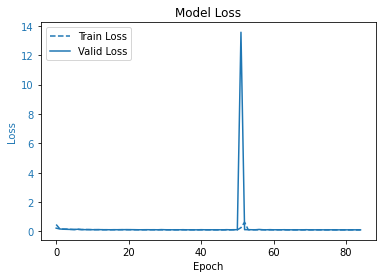

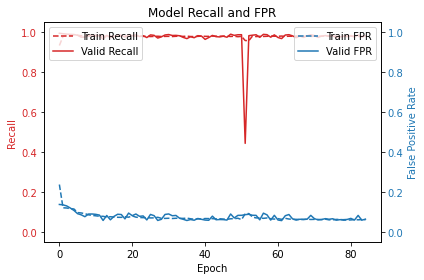

MODEL - 2


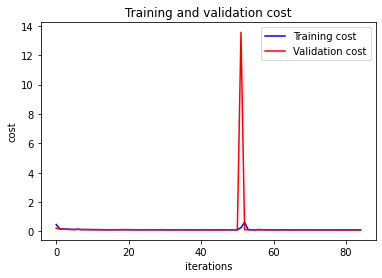

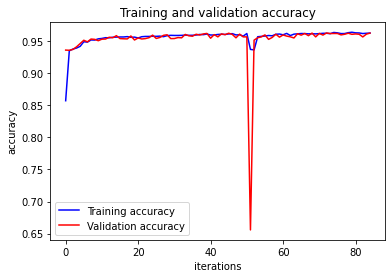

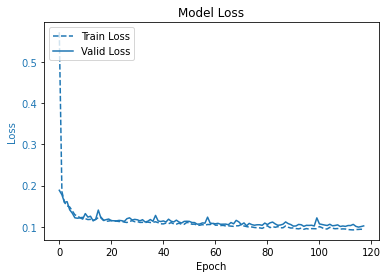

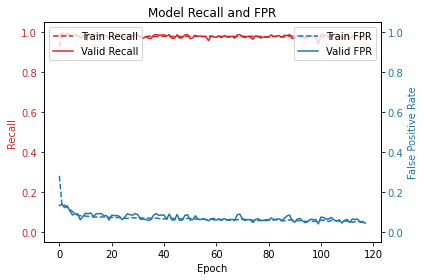

MODEL - 3


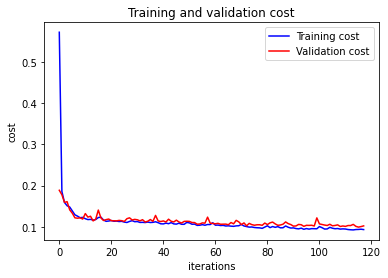

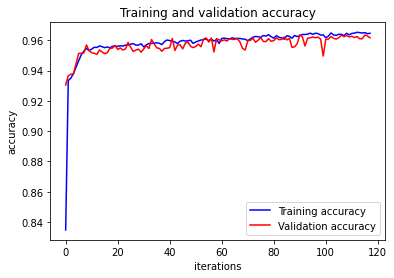

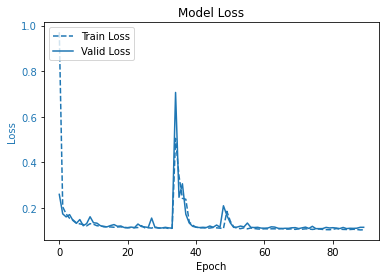

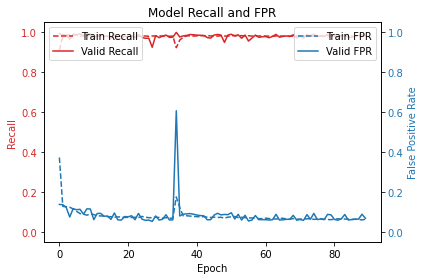

MODEL - 4


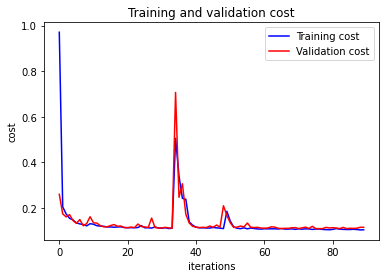

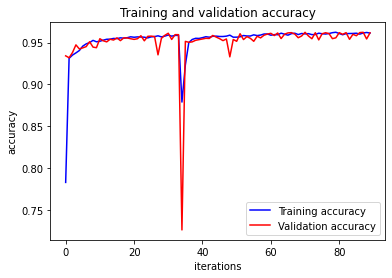

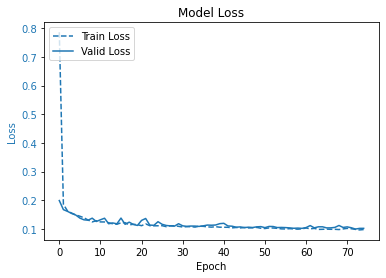

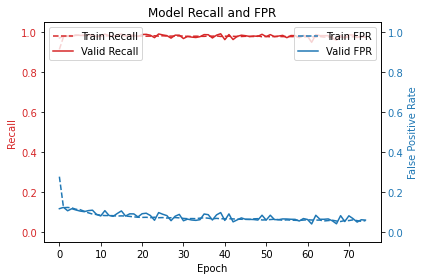

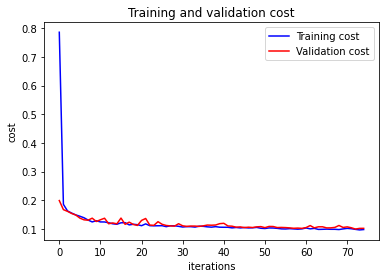

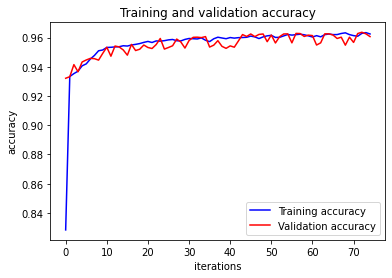

In [39]:
#Graphs
print("MODEL - 1")
plot_loss(history)
plot_model_recall_fpr(history)
plot_train_history(history)
print("MODEL - 2")
plot_loss(h2)
plot_model_recall_fpr(h2)
plot_train_history(h2)
print("MODEL - 3")
plot_loss(h3)
plot_model_recall_fpr(h3)
plot_train_history(h3)
print("MODEL - 4")
plot_loss(h4)
plot_model_recall_fpr(h4)
plot_train_history(h4)

In [40]:
mlp.save('model1.h5')

In [41]:
mlp2.save('model2.h5')

In [42]:
mlp3.save('model3.h5')

In [43]:
mlp4.save('model4.h5')

In [44]:
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# Specify the filename
		filename = '/content/model' + str(i + 1) + '.h5'
		# load the model 
		model = load_model(filename,custom_objects=dependencies)
		# Add a list of all the weaker learners
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [45]:
dependencies = {'FalsePositiveRate': FalsePositiveRate}

n_members = 4
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded /content/model1.h5
>loaded /content/model2.h5
>loaded /content/model3.h5
>loaded /content/model4.h5
Loaded 4 models


In [46]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat #
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [47]:
# fit a model based on the outputs from the ensemble members
# 1 - Logistic Regression
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit the meta learner
	model = LogisticRegression() #meta learner
	model.fit(stackedX, inputy)
	return model
model = fit_stacked_model(members, X_test_fs,y_test)

In [48]:
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
# evaluate model on test set -
yhat = stacked_prediction(members, model, X_test_fs)
score = accuracy_score(y_test/1.0, yhat/1.0)
print('Stacked Score with Logistic Regression:', score)

Stacked Score with Logistic Regression: 0.963033627474362


In [49]:
# fit a model based on the outputs from the ensemble members
# 2 - Gradient Boosting Machine
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit the meta learner
	model = GradientBoostingClassifier() #meta learner
	model.fit(stackedX, inputy)
	return model
stackedmodel2 = fit_stacked_model(members, X_test_fs,y_test)

In [50]:
yhat2 = stacked_prediction(members, stackedmodel2, X_test_fs)
score2 = accuracy_score(y_test/1.0, yhat2/1.0)
print('Stacked Score with Gradient Boosting Machine:', score2)

Stacked Score with Gradient Boosting Machine: 0.9720963510612927
